#DATASCI W261, Machine Learning at Scale
--------
####Assignement:  week \#7
####[Lei Yang](mailto:leiyang@berkeley.edu) | [Michael Kennedy](mailto:mkennedy@ischool.berkeley.edu) | [Natarajan Krishnaswami](mailto:natarajan@krishnaswami.org)
####Due: 2016-03-10, 8AM PST

###General Description
In this assignment you will explore networks and develop MRJob code for 
finding shortest path graph distances. To build up to large data 
you will develop your code on some very simple, toy networks.
After this you will take your developed code forward and modify it and 
apply it to two larger datasets (performing EDA along the way).


####Undirected toy network dataset

In an undirected network all links are symmetric, 
i.e., for a pair of nodes 'A' and 'B,' both of the links:

A -> B and B -> A

will exist. 

The toy data are available in a sparse (stripes) representation:

(node) \t (dictionary of links)

on AWS/Dropbox via the url:

s3://ucb-mids-mls-networks/undirected_toy.txt

On under the Data Subfolder for HW7 on Dropbox with the same file name

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).


####Directed toy network dataset

In a directed network all links are not necessarily symmetric, 
i.e., for a pair of nodes 'A' and 'B,' it is possible for only one of:

A -> B or B -> A

to exist. 

These toy data are available in a sparse (stripes) representation:

(node) \t (dictionary of links)

on AWS/Dropbox via the url:

s3://ucb-mids-mls-networks/directed_toy.txt

On under the Data Subfolder for HW7 on Dropbox with the same file name

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).


###HW 7.0: Shortest path graph distances (toy networks)

In this part of your assignment you will develop the base of your code for the week.

Write MRJob classes to find shortest path graph distances, 
as described in the lectures. In addition to finding the distances, 
your code should also output a distance-minimizing path between the source and target.
Work locally for this part of the assignment, and use 
both of the undirected and directed toy networks.

To proof you code's function, run the following jobs

- shortest path in the undirected network from node 1 to node 4

Solution: 1,5,4 

- shortest path in the directed network from node 1 to node 5

Solution: 1,2,4,5

and report your output---make sure it is correct!

###One Iteration BFS Mrjob
<img src="ShortestPathMapReduce.png" alt="Drawing" style="width: 550px;"/>

In [29]:
%%writefile ShortestPathIter.py
from mrjob.job import MRJob
from mrjob.step import MRStep


class ShortestPathIter(MRJob):
    DEFAULT_PROTOCOL = 'json'

    def __init__(self, *args, **kwargs):
        super(ShortestPathIter, self).__init__(*args, **kwargs)


    def configure_options(self):
        super(ShortestPathIter, self).configure_options()
        self.add_passthrough_option(
            '--source', dest='source', default='1', type='string',
            help='source: source node (default 1)')
        self.add_passthrough_option(
            '--destination', dest='destination', default='1', type='string',
            help='destination: destination node (default 1)')

    def mapper(self, _, line):
        nid, dic = line.strip().split('\t', 1)
        cmd = 'node = %s' %dic
        exec cmd
        # if the node structure is incomplete (first pass), add them
        if 'dist' not in node:
            node = {'adj':node, 'path':[]}
            node['dist'] = 0 if self.options.source==nid else -1
        # emit node
        yield nid, node
        # emit distances to reachable nodes
        if node['dist'] >= 0:
            for m in node['adj']:
                yield m, {'dd':node['adj'][m] + node['dist'], 'pp':node['path']+[nid]}

    def reducer(self, nid, value):        
        dmin = float('inf')
        path = node = None
        # loop through all arrivals
        for v in value:
            if 'dist' in v:
                node = v
            elif v['dd'] < dmin:
                dmin = v['dd']
                path = v['pp']

        # handle dangling node, we only care if it's destination
        if not node:
            if nid == self.options.destination:
                node = {'adj':{}, 'dist':dmin, 'path':path}
                self.increment_counter('weighted', 'dist_changed', 1)
            else:
                return
        elif (node['dist'] == -1 and path) or dmin < node['dist']:
            node['dist'], node['path'] = dmin, path
            self.increment_counter('weighted', 'dist_changed', 1)

        # emit for next iteration
        yield nid, node

    def steps(self):
        jc = {
            'mapreduce.job.maps': '2',
            'mapreduce.job.reduces': '2',
        }
        return [MRStep(mapper=self.mapper
                       , combiner=self.reducer
                       , reducer=self.reducer
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    ShortestPathIter.run()


Overwriting ShortestPathIter.py


In [23]:
##### unit test #####
#!python ShortestPathIter.py undirected_toy.txt --source 1 --destination 4 -r 'hadoop'


###MrJob to retrieve path

In [30]:
%%writefile getPath.py
from mrjob.job import MRJob
from mrjob.step import MRStep


class getPath(MRJob):
    DEFAULT_PROTOCOL = 'json'

    def __init__(self, *args, **kwargs):
        super(getPath, self).__init__(*args, **kwargs)

    def configure_options(self):
        super(getPath, self).configure_options()        
        self.add_passthrough_option(
            '--destination', dest='destination', default='1', type='string',
            help='destination: destination node (default 1)')

    def mapper_init(self):
        self.path = None

    def mapper(self, _, line):
        nid, dic = line.strip().split('\t', 1)
        #nid = nid.strip('"')
        # emit distances to reachable nodes
        if nid.strip('"') == self.options.destination:
            cmd = 'node = %s' %dic
            exec cmd
            self.path = node['path']            

    def mapper_final(self):
        if self.path:
            yield "shortest path", self.path

    def steps(self):
        jc = {
            'mapreduce.job.maps': '1',
        }
        return [MRStep(mapper_init=self.mapper_init
                       , mapper=self.mapper
                       , mapper_final=self.mapper_final
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    getPath.run()


Overwriting getPath.py


###Driver Program
- init_job: take raw import, do first level traverse, output intermediate graph file
- iter_job: iteratively traverse the graph and update the shortest distance and path

In [41]:
%%writefile RunBFS.py
#!/usr/bin/python
from ShortestPathIter import ShortestPathIter
from getPath import getPath
from subprocess import call
import sys, getopt, datetime

# parse parameter
if __name__ == "__main__":

    try:
        opts, args = getopt.getopt(sys.argv[1:], "hg:s:d:m:")
    except getopt.GetoptError:
        print 'RunUnweightedBFS.py -g <graph> -s <source> -d <destination> -m <mode>'
        sys.exit(2)
    if len(opts) != 4:
        print 'RunUnweightedBFS.py -g <graph> -s <source> -d <destination> -m <mode>'
        sys.exit(2)
    for opt, arg in opts:
        if opt == '-h':
            print 'RunUnweightedBFS.py -g <graph> -s <source> -d <destination> -m <mode>'
            sys.exit(2)
        elif opt == '-g':
            graph = arg
        elif opt == '-s':
            source = arg
        elif opt == '-d':
            destination = arg
        elif opt == '-m':
            mode = arg


# creat BFS job
init_job = ShortestPathIter(args=[graph, '--source', source, '--destination', destination,
                                            '-r', mode, '--output-dir', 'hdfs:///user/leiyang/out'])

iter_job = ShortestPathIter(args=['hdfs:///user/leiyang/in/part*', '--source', source, '--destination',
                                            destination, '-r', mode, '--output-dir', 'hdfs:///user/leiyang/out'])

path_job = getPath(args=['hdfs:///user/leiyang/out/part*', '--destination', destination, '-r', mode])

# run initialization job
with init_job.make_runner() as runner:
    print str(datetime.datetime.now()) + ': starting initialization job ...'
    runner.run()
    print runner.counters() #['weighted']['dist_changed']
# move the result to input folder
#print str(datetime.datetime.now()) + ': node number with distance change: ' + n_change
print str(datetime.datetime.now()) + ': moving results for next initialization ...'
call(['hdfs', 'dfs', '-mv', '/user/leiyang/out', '/user/leiyang/in'])


# run BFS iteratively
i = 1
while(0):
    stop = False
    with iter_job.make_runner() as runner:
        print str(datetime.datetime.now()) + ': running iteration %d ...' %i
        runner.run()
        # check if destination is reached: no counter is called
        stop = 'unweighted' not in runner.counters()

    # if destination reached, get path and break out
    if stop:
        print str(datetime.datetime.now()) + ': destination is reached, retrieving path ...'
        with path_job.make_runner() as runner:
            runner.run()
            for line in runner.stream_output():
                text, path = stop_job.parse_output_line(line)
                result = ': shortest path: %s' %(' -> '.join(path+[destination]))
        break

    # more iteration needed
    i += 1
    print str(datetime.datetime.now()) + ': moving results for next initialization ...'
    call(['hdfs', 'dfs', '-rm', '-r', '/user/leiyang/in'])
    call(['hdfs', 'dfs', '-mv', '/user/leiyang/out', '/user/leiyang/in'])

# clear results
print str(datetime.datetime.now()) + ': clearing files ...'
call(['hdfs', 'dfs', '-rm', '-r', '/user/leiyang/in'])
call(['hdfs', 'dfs', '-rm', '-r', '/user/leiyang/out'])

print str(datetime.datetime.now()) + ": traversing completes!"
print str(datetime.datetime.now()) + result


Overwriting RunBFS.py


###Evaluation

In [43]:
!echo 'The shortest path in the undirected network from node 1 to node 4:'
!python RunBFS.py -s 1 -d 4 -m 'inline' -g 'undirected_toy.txt' #'hdfs:///user/leiyang/undirected_toy.txt'

#!echo '\nThe shortest path in the directed network from node 1 to node 5:'
#!python RunBFS.py -s 1 -d 5 -m 'hadoop' -g directed_toy.txt


The shortest path in the undirected network from node 1 to node 4:
2016-03-04 00:33:31.819510: starting initialization job ...
No handlers could be found for logger "mrjob.compat"
[{'weighted': {'dist_changed': 1}}]
2016-03-04 00:33:31.851537: moving results for next initialization ...
mv: `/user/leiyang/out': No such file or directory
2016-03-04 00:33:33.426374: clearing files ...
rm: `/user/leiyang/in': No such file or directory
rm: `/user/leiyang/out': No such file or directory
2016-03-04 00:33:36.452201: traversing completes!
Traceback (most recent call last):
  File "RunBFS.py", line 84, in <module>
    print str(datetime.datetime.now()) + result
NameError: name 'result' is not defined


###Main dataset 1: NLTK synonyms

- In the next part of this assignment you will explore a network derived from
the NLTK synonym database used for evaluation in HW 5. 
- At a high level, this network is undirected, defined so that there exists link between two nodes/words 
if the pair or words are a synonym. 

These data may be found at the location:

- s3://ucb-mids-mls-networks/synNet/synNet.txt
- s3://ucb-mids-mls-networks/synNet/indices.txt

On under the Data Subfolder for HW7 on Dropbox with the same file names

where synNet.txt contains a sparse representation of the network:

(index) \t (dictionary of links)

in indexed form, and indices.txt contains a lookup list

(word) \t (index)

of indices and words. This network is small enough for you to explore and run
scripts locally, but will also be good for a systems test (for later) on AWS.

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).

###HW 7.1: Exploratory data analysis (NLTK synonyms)

Using MRJob, explore the synonyms network data.
Consider plotting the degree distribution (does it follow a power law?),
and determine some of the key features, like:

- number of nodes, 
- number links,
- or the average degree (i.e., the average number of links per node),
- etc...

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

###MrJob to explore the graph

In [1]:
%%writefile ExploreGraph.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class ExploreGraph(MRJob):
    
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        super(ExploreGraph, self).__init__(*args, **kwargs)

    # assuming we are dealing with directed graph
    # this job can handle undirected graph as well, 
    # but it can be done more efficiently
    def mapper(self, _, line):
        nid, dic = line.strip().split('\t', 1)
        cmd = 'adj = %s' %dic
        exec cmd        
        # we need to emit node ID as key, in order to count dangling nodes
        # the value emitted here is (out, in) degree for the node
        yield nid, (len(adj), 0)
        # emit in degree from adjacency list
        for n in adj:
            yield n, (0, 1)
                        
    def combiner(self, nid, deg):
        din = dout = 0
        for d in deg:            
            dout += d[0]
            din += d[1]            
        yield nid, (dout, din)
        
    def reducer_init(self):
        self.node_cnt = 0
        self.out_deg = {}
        self.in_deg = {}
        
    def reducer(self, node, deg):
        # add node by 1
        self.node_cnt += 1
        # aggregate in/out degree
        _out = _in = 0
        for d in deg:            
            _out += d[0]
            _in += d[1]    
        # accumulate degree distribution
        if _out not in self.out_deg:
            self.out_deg[_out] = 1
        else:
            self.out_deg[_out] += 1
        if _in not in self.in_deg:
            self.in_deg[_in] = 1
        else:
            self.in_deg[_in] += 1
        
            
    def reducer_final(self):
        # final aggregation        
        tot_degree = sum([d*self.out_deg[d] for d in self.out_deg])
        yield 'total nodes: ', self.node_cnt
        yield 'total links: ', tot_degree
        yield 'average in degree: ', 1.0*tot_degree/sum(self.in_deg.values())
        yield 'average out degree: ', 1.0*tot_degree/sum(self.out_deg.values())
        yield 'dist of in-degree: ', self.in_deg
        yield 'dist of out-degree: ', self.out_deg
        
    def steps(self):
        jc = {
            'mapreduce.job.maps': '10',
            'mapreduce.job.reduces': '1',
        }
        return [MRStep(mapper=self.mapper
                       , combiner=self.combiner
                       , reducer_init=self.reducer_init
                       , reducer=self.reducer                       
                       , reducer_final=self.reducer_final
                       #, jobconf = jc
                      )
               ]

if __name__ == '__main__':
    ExploreGraph.run()


Overwriting ExploreGraph.py


###Explore NLTK Synonyms Net

In [2]:
!python ExploreGraph.py randNet.txt -r 'inline' > sumstats
!echo '\nSummary stats of the graph:'
!cat sumstats

using configs in /Users/leiyang/.mrjob.conf
creating tmp directory /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/ExploreGraph.leiyang.20160301.010635.985096
writing to /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/ExploreGraph.leiyang.20160301.010635.985096/step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/ExploreGraph.leiyang.20160301.010635.985096/step-0-mapper-sorted
> sort /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/ExploreGraph.leiyang.20160301.010635.985096/step-0-mapper_part-00000
writing to /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/ExploreGraph.leiyang.20160301.010635.985096/step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/ExploreGraph.leiyang.20160301.010635.985096/step-0-reducer_part-00000 -> /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/ExploreGraph.leiyang.20160301.010635.985096/output/part-00000
Str

###Node degree distribution

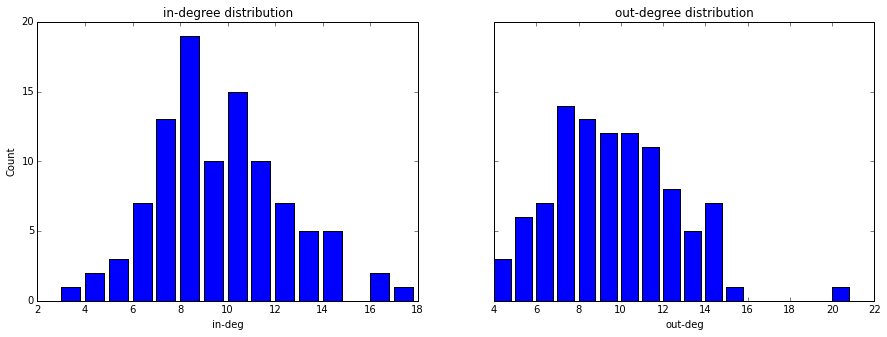

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
in_deg = {"3": 1, "4": 2, "5": 3, "6": 7, "7": 13, "8": 19, "9": 10, "10": 15, "11": 10, "12": 7, "13": 5, "14": 5, "16": 2, "17": 1}
out_deg = {"4": 3, "5": 6, "6": 7, "7": 14, "8": 13, "9": 12, "10": 12, "11": 11, "12": 8, "13": 5, "14": 7, "15": 1, "20": 1}
# plot the in/out distribution histogram
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches([15,5])
ax1.bar([int(k) for k in in_deg.keys()], in_deg.values())
ax1.set_title('in-degree distribution')
ax1.set_ylabel('Count')
ax1.set_xlabel('in-deg')
ax2.bar([int(k) for k in out_deg.keys()], out_deg.values())
ax2.set_title('out-degree distribution')
ax2.set_xlabel('out-deg')
plt.show()

###HW 7.2: Shortest path graph distances (NLTK synonyms)

Write (reuse your code from 7.0) an MRJob class to find shortest path graph distances, 
and apply it to the NLTK synonyms network dataset. 

Proof your code's function by running the job:

- shortest path starting at "walk" (index=7827) and ending at "make" (index=536),

and showing you code's output. Once again, your output should include the path and the distance.

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

In [49]:
##### execute RunBFS.py from HW 7.0 #####
!python RunBFS.py -g randNet.txt -d 34 -s 58 -m 'inline'

iteration 1
iteration 2
iteration 3
iteration 4
Traversing completes!

shortest distance between 58 and 34: 2
path: 58 -> 21 -> 34


###Main dataset 2: English Wikipedia

For the remainder of this assignment you will explore the English Wikipedia hyperlink network.
The dataset is built from the Sept. 2015 XML snapshot of English Wikipedia.
For this directed network, a link between articles: 

A -> B

is defined by the existence of a hyperlink in A pointing to B.
This network also exists in the indexed format:

- s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt
- s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt
- s3://ucb-mids-mls-networks/wikipedia/indices.txt

On under the Data Subfolder for HW7 on Dropbox with the same file names

but has an index with more detailed data:

(article name) \t (index) \t (in degree) \t (out degree)

In the dictionary, target nodes are keys, link weights are values .
Here, a weight indicates the number of time a page links to another.
However, for the sake of this assignment, treat this an unweighted network,
and set all weights to 1 upon data input.

###HW 7.3: Exploratory data analysis (Wikipedia)

Using MRJob, explore the Wikipedia network data on the AWS cloud. Reuse your code from HW 7.1---does is scale well? 
Be cautioned that Wikipedia is a directed network, where links are not symmetric. 
So, even though a node may be linked to, it will not appear as a primary record itself if it has no out-links. 
This means that you may have to ADJUST your code (depending on its design). 
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.


In [1]:
#!python ExploreGraph.py 'all-pages-indexed-out.txt' -r 'hadoop' --cleanup 'NONE' > wiki_sumstats
!cat wiki_explore_emr.txt

[hadoop@ip-172-31-1-180 lei_wiki]$ ls -l
total 2041476
-rw-rw-r-- 1 hadoop hadoop 2090459616 Oct 22 02:29 all-pages-indexed-out.txt
-rw-rw-r-- 1 hadoop hadoop       2655 Mar  1 01:57 ExploreGraph.py
[hadoop@ip-172-31-1-180 lei_wiki]$ python ExploreGraph.py 'all-pages-indexed-out.txt' -r 'hadoop' --cleanup 'NONE' > wiki_sumstats
using configs in /home/hadoop/.mrjob.conf
creating tmp directory /tmp/ExploreGraph.hadoop.20160301.015847.095270
writing wrapper script to /tmp/ExploreGraph.hadoop.20160301.015847.095270/setup-wrapper.sh
Using Hadoop version 2.7.1
Copying local files into hdfs:///user/hadoop/tmp/mrjob/ExploreGraph.hadoop.20160301.015847.095270/files/
HADOOP: packageJobJar: [] [/usr/lib/hadoop/hadoop-streaming-2.7.1-amzn-0.jar] /tmp/streamjob2321478639392700904.jar tmpDir=null
HADOOP: Connecting to ResourceManager at ip-172-31-1-180.ec2.internal/172.31.1.180:8032
HADOOP: Connecting to ResourceManager at ip-172-31-1-180.ec2.internal/172.31.1.180:8032
HADOOP: MetricsConfigRecord di

"total nodes: "	15192277
"total links: "	142114057
"average in degree: "	9.354361890584276
"average out degree: "	9.354361890584276


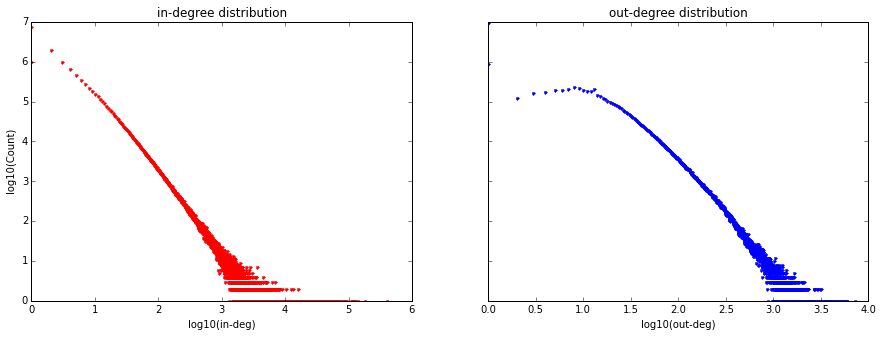

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from math import log10

with open('wiki_sumstats_emr.txt', 'r') as f:
    lines = f.readlines()
for line in lines:
    if 'dist of' not in line:
        print line.strip()
    else:
        dc, dic = line.split('\t')
        cmd = '%s = %s' %('in_deg' if 'in' in dc else 'out_deg', dic)
        exec cmd
        
#plt.plot([log10(int(k)) for k in degrees.keys()], degrees.values(), 'r.')
#plt.xlabel('log(Node Degree)')
#plt.ylabel('Count')
#plt.show()

# plot the in/out distribution histogram
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches([15,5])
ax1.plot([0 if k=='0' else log10(int(k)) for k in in_deg.keys()], 
         [0 if i=='0' else log10(i) for i in in_deg.values()], 'r.')
ax1.set_title('in-degree distribution')
ax1.set_ylabel('log10(Count)')
ax1.set_xlabel('log10(in-deg)')
ax2.plot([0 if k=='0' else log10(int(k)) for k in out_deg.keys()], 
         [0 if k=='0' else log10(k) for k in out_deg.values()], 'b.')
ax2.set_title('out-degree distribution')
ax2.set_xlabel('log10(out-deg)')
plt.show()

In [25]:
print in_deg['2']


1950499


###HW 7.4: Shortest path graph distances (Wikipedia)

Using MRJob, find shortest path graph distances in the Wikipedia network on the AWS cloud.
Reuse your code from 7.2, but once again be warned of Wikipedia being a directed network.
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

When running your code on the Wikipedia network, proof its function by running the job:

- shortest path from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359),

and show your code's output.

Once your code is running, find some other shortest paths and report your results.

###Two changes to improve performance for unweighted graph
- in iteration mrjob: no need to store weight value, to reduce the amount of data during processing
- in driver program: the stopping criterion for unweighted network is simpler: once the destination becomes frontier, it has the shortest path from the source

###Mrjob for unweighted BFS iteration

In [41]:
%%writefile UnweightedShortestPathIter.py
from mrjob.job import MRJob
from mrjob.step import MRStep


class UnweightedShortestPathIter(MRJob):
    DEFAULT_PROTOCOL = 'json'

    def __init__(self, *args, **kwargs):
        super(UnweightedShortestPathIter, self).__init__(*args, **kwargs)

    def configure_options(self):
        super(UnweightedShortestPathIter, self).configure_options()
        self.add_passthrough_option(
            '--source', dest='source', default='1', type='string',
            help='source: source node (default 1)')
        self.add_passthrough_option(
            '--destination', dest='destination', default='1', type='string',
            help='destination: destination node (default 1)')

    def mapper(self, _, line):
        nid, dic = line.strip().split('\t', 1)
        nid = nid.strip('"')
        cmd = 'node = %s' %dic
        exec cmd
        # if the node structure is incomplete (first pass), add them
        if 'dist' not in node:
            node = {'adj':node.keys(), 'path':[]}
            node['dist'] = 0 if self.options.source==nid else -1
        # emit node
        yield nid, node
        # emit distances to reachable nodes
        if node['dist'] >= 0:
            for m in node['adj']:
                yield m, {'dd':(1+node['dist']), 'pp':(node['path']+[nid])}

    def reducer(self, nid, value):
        dmin = float('inf')
        path = node = None
        # loop through all arrivals
        for v in value:
            if 'dist' in v:
                node = v
            elif v['dd'] < dmin:
                dmin = v['dd']
                path = v['pp']
        # handle dangling node, we only care if it's destination
        isDestination = nid == self.options.destination
        if not node:
            if isDestination:
                node = {'adj':[], 'dist':dmin, 'path':path}
            else:
                return
        elif (node['dist'] == -1 and path) or dmin < node['dist']:
            node['dist'], node['path'] = dmin, path
             
        # set the counter so we can stop iteration after the job is done
        if isDestination and node['dist'] > 0:
            self.increment_counter('unweighted', 'reached', 1)
        # emit for next iteration
        yield nid, node

    def steps(self):
        jc = {
            'mapreduce.job.maps': '16',
            'mapreduce.job.reduces': '16',
        }
        return [MRStep(mapper=self.mapper
                       , combiner=self.reducer
                       , reducer_init=self.reducer_init
                       , reducer=self.reducer
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    UnweightedShortestPathIter.run()



Overwriting UnweightedShortestPathIter.py


###MrJob for checking stop criterion

In [71]:
%%writefile isDestinationReached.py
from mrjob.job import MRJob
from mrjob.step import MRStep


class isDestinationReached(MRJob):
    DEFAULT_PROTOCOL = 'json'

    def __init__(self, *args, **kwargs):
        super(isDestinationReached, self).__init__(*args, **kwargs)

    def configure_options(self):
        super(isDestinationReached, self).configure_options()
        self.add_passthrough_option(
            '--source', dest='source', default='1', type='string',
            help='source: source node (default 1)')
        self.add_passthrough_option(
            '--destination', dest='destination', default='1', type='string',
            help='destination: destination node (default 1)')

    def mapper_init(self):
        self.path = None

    def mapper(self, _, line):
        nid, dic = line.strip().split('\t', 1)
        #nid = nid.strip('"')
        # emit distances to reachable nodes
        if nid.strip('"') == self.options.destination:
            cmd = 'node = %s' %dic
            exec cmd
            self.path = node['path']            

    def mapper_final(self):
        if self.path:
            yield "shortest path", self.path

    def steps(self):
        jc = {
            'mapreduce.job.maps': '16',
        }
        return [MRStep(mapper_init=self.mapper_init
                       , mapper=self.mapper
                       , mapper_final=self.mapper_final
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    isDestinationReached.run()


Overwriting isDestinationReached.py


###Driver program for unweighted BFS

In [6]:
%%writefile RunUnweightedBFS.py
#!/usr/bin/python
from UnweightedShortestPathIter import UnweightedShortestPathIter
from isDestinationReached import isDestinationReached
from subprocess import call
import sys, getopt, datetime

# parse parameter
if __name__ == "__main__":

    try:
        opts, args = getopt.getopt(sys.argv[1:], "hg:s:d:m:")
    except getopt.GetoptError:
        print 'RunUnweightedBFS.py -g <graph> -s <source> -d <destination> -m <mode>'
        sys.exit(2)
    if len(opts) != 4:
        print 'RunUnweightedBFS.py -g <graph> -s <source> -d <destination> -m <mode>'
        sys.exit(2)
    for opt, arg in opts:
        if opt == '-h':
            print 'RunUnweightedBFS.py -g <graph> -s <source> -d <destination> -m <mode>'
            sys.exit(2)
        elif opt == '-g':
            graph = arg
        elif opt == '-s':
            source = arg
        elif opt == '-d':
            destination = arg
        elif opt == '-m':
            mode = arg


# creat BFS job
init_job = UnweightedShortestPathIter(args=[graph, '--source', source, '--destination', destination,
                                            '-r', mode, '--output-dir', 'hdfs:///user/leiyang/wiki_out'])

iter_job = UnweightedShortestPathIter(args=['hdfs:///user/leiyang/wiki_in/part*', '--source', source, '--destination',
                                            destination, '-r', mode, '--output-dir', 'hdfs:///user/leiyang/wiki_out'])

stop_job = isDestinationReached(args=['hdfs:///user/leiyang/wiki_out/part*', '--source', source, '--destination',
                                            destination, '-r', mode])

# run initialization job
with init_job.make_runner() as runner:
    print str(datetime.datetime.now()) + ': starting initialization job ...'
    runner.run()
# move the result to input folder
print str(datetime.datetime.now()) + ': moving results for next initialization ...'
call(['hdfs', 'dfs', '-mv', '/user/leiyang/wiki_out', '/user/leiyang/wiki_in'])


# run BFS iteratively
i = 1
while(1):
    stop = False
    with iter_job.make_runner() as runner:
        print str(datetime.datetime.now()) + ': running iteration %d ...' %i
        runner.run()
        # check if destination is reached
        stop = runner.counters()['unweighted']['reached'] == 1

    # if destination reached, get path and break out
    if stop:
        print str(datetime.datetime.now()) + ': destination is reached, retrieving path ...'
        with stop_job.make_runner() as runner:
            runner.run()
            for line in runner.stream_output():
                text, path = stop_job.parse_output_line(line)
                result = '\nshortest path: %s' %(' -> '.join(path+[destination]))
        break

    # more iteration needed
    i += 1
    print str(datetime.datetime.now()) + ': moving results for next initialization ...'
    call(['hdfs', 'dfs', '-rm', '-r', '/user/leiyang/wiki_in'])
    call(['hdfs', 'dfs', '-mv', '/user/leiyang/wiki_out', '/user/leiyang/wiki_in'])

# clear results
print str(datetime.datetime.now()) + ': clearing files ...'
call(['hdfs', 'dfs', '-rm', '-r', '/user/leiyang/wiki*'])

print str(datetime.datetime.now()) + ": traversing completes!"
print result


Overwriting RunUnweightedBFS.py


###Unit test of unweighted BFS

In [5]:
# !python RunBFS.py -g randNet.txt -d 34 -s 58 -m 'inline'

#!python UnweightedShortestPathIter.py 'directed_toy.txt' --source 1 --destination 6 -r 'inline' 
#'--output-dir' '/user/leiyang/wiki_out/'

#!python UnweightedShortestPathIter.py 'hdfs:///user/leiyang/randNet.txt' --source 34 --destination 58 -r 'hadoop' \
#'--output-dir' 'hdfs:///user/leiyang/wiki_out'

#!python UnweightedShortestPathIter.py 'hdfs:///user/leiyang/wiki_in/part*' --source 34 --destination 58 -r 'hadoop' \
#'--output-dir' 'hdfs:///user/leiyang/wiki_out'

#!python isDestinationReached.py 'hdfs:///user/leiyang/wiki_out/part*' --source 34 --destination 58 -r 'hadoop'

#!hdfs dfs -cat /user/leiyang/wiki_out/p*

#!python RunUnweightedBFS.py -g 'hdfs:///user/leiyang/randNet.txt' -s 36 -d 66 -m 'hadoop' 
!cat wiki_log_1

[hadoop@ip-172-31-6-190 lei]$ python RunUnweightedBFS.py -s '6176135' -d '13466359' -m 'hadoop' -g 'hdfs:///user/leiyang/all-pages-indexed-out.txt'
No handlers could be found for logger "mrjob.conf"
starting initialization job ...
moving results for next initialization ...
running iteration 1 ...
checking if destination is reached ...
moving results for next initialization ...
16/03/03 06:12:51 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/leiyang/wiki_in
running iteration 2 ...
checking if destination is reached ...
Destination reached, clearing files ...
16/03/03 06:28:52 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/leiyang/wiki_in
16/03/03 06:28:52 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/leiyang/wiki_out
Traversing comp

###BFS on Wikipedia dataset

In [94]:
#!python RunUnweightedBFS.py -s '6176135' -d '13466359' -m 'hadoop' -g 'hdfs:///user/leiyang/all-pages-indexed-out.txt'
!cat wiki_log

Overwriting FindWikiShortestPath.sh


###HW 7.5: Conceptual exercise: Largest single-source network distances

Suppose you wanted to find the largest network distance from a single source,
i.e., a node that is the furthest (but still reachable) from a single source.

How would you implement this task? 
How is this different from finding the shortest path graph distances?

Is this task more difficult to implement than the shortest path distance?

As you respond, please comment on program structure, runtimes, iterations, general system requirements, etc...

###Answer:
- change the distance comparison step, instead of keeping smaller distance, choose larger distance here

###HW 7.6 (optional): Computational exercise: Largest single-source network distances 

Using MRJob, write a code to find the largest graph distance and distance-maximizing nodes from a single-source.
Test your code first on the toy networks and synonyms network to proof its function.

###stop yarn, hdfs, and job history

In [9]:
!/usr/local/Cellar/hadoop/2*/sbin/stop-yarn.sh
!/usr/local/Cellar/hadoop/2*/sbin/stop-dfs.sh
!/usr/local/Cellar/hadoop/2*/sbin/mr-jobhistory-daemon.sh --config /usr/local/Cellar/hadoop/2*/libexec/etc/hadoop/ stop historyserver 

stopping yarn daemons
stopping resourcemanager
localhost: stopping nodemanager
localhost: nodemanager did not stop gracefully after 5 seconds: killing with kill -9
no proxyserver to stop
Stopping namenodes on [localhost]
localhost: stopping namenode
localhost: stopping datanode
Stopping secondary namenodes [0.0.0.0]
0.0.0.0: stopping secondarynamenode
stopping historyserver


###start yarn, hdfs, and job history

In [16]:
!/usr/local/Cellar/hadoop/2*/sbin/start-yarn.sh
!/usr/local/Cellar/hadoop/2*/sbin/start-dfs.sh
!/usr/local/Cellar/hadoop/2*/sbin/mr-jobhistory-daemon.sh --config /usr/local/Cellar/hadoop/2*/libexec/etc/hadoop/ start historyserver 

starting yarn daemons
starting resourcemanager, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/yarn-leiyang-resourcemanager-Leis-MacBook-Pro.local.out
localhost: starting nodemanager, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/yarn-leiyang-nodemanager-Leis-MacBook-Pro.local.out
Starting namenodes on [localhost]
localhost: starting namenode, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/hadoop-leiyang-namenode-Leis-MacBook-Pro.local.out
localhost: starting datanode, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/hadoop-leiyang-datanode-Leis-MacBook-Pro.local.out
Starting secondary namenodes [0.0.0.0]
0.0.0.0: starting secondarynamenode, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/hadoop-leiyang-secondarynamenode-Leis-MacBook-Pro.local.out
starting historyserver, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/mapred-leiyang-historyserver-Leis-MacBook-Pro.local.out
16/03/03 23:46:40 INFO hs.JobHistoryServer: STARTUP_MSG: 
/**********